## Problem Overview
Hypertrophic cardiomyopathy (cardiomegaly) is a genetic condition where the heart muscle becomes abnormally thickened, making it harder for the heart to pump blood.
This project aims to develop a machine learning model that can accurately detect cardiomegaly from data about chest X-ray images using data from the `task_data.csv` file.

### Imports

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

### Loading the Data

In [106]:
df = pd.read_csv("task_data.csv", decimal=',')
print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")

Dataset loaded successfully!
Shape: (37, 14)


### Data Overview

In [107]:
df.head()

,ID,Cardiomegaly,Heart width,Lung width,CTR - Cardiothoracic Ratio,xx,yy,xy,normalized_diff,Inscribed circle radius,Polygon Area Ratio,Heart perimeter,Heart area,Lung area
0,1,0,172,405,0.424691,1682.3608714590994,3153.671880299657,-638.5311091794423,-0.3042392565074078,68.81860,0.21344605475040257,679.487369,24898,75419
1,2,1,159,391,0.406650,1526.660959877028,5102.159053732461,-889.6784046829048,-0.5393868119084021,73.92564,0.20365244865718798,788.658942,29851,94494
2,5,0,208,400,0.520000,2465.9033921095847,5376.834706657514,-1755.3446985706441,-0.3711626319646625,69.33974,0.32078694801818824,862.322937,33653,66666
3,7,1,226,435,0.519540,2509.0635928775273,6129.821269595383,-1025.0798057957954,-0.4191232704635678,84.14868,0.3175446107949837,906.724959,42018,82596
4,8,1,211,420,0.502381,2368.7701350238644,5441.767074886623,-1493.0400615856156,-0.3934424556563858,73.78347,0.2635421805624075,864.239678,35346,85631


In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          37 non-null     int64  
 1   Cardiomegaly                37 non-null     int64  
 2   Heart width                 37 non-null     int64  
 3   Lung width                  37 non-null     int64  
 4   CTR - Cardiothoracic Ratio  37 non-null     float64
 5   xx                          37 non-null     object 
 6   yy                          37 non-null     object 
 7   xy                          37 non-null     object 
 8   normalized_diff             37 non-null     object 
 9   Inscribed circle radius     37 non-null     float64
 10  Polygon Area Ratio          37 non-null     object 
 11  Heart perimeter             37 non-null     float64
 12  Heart area                  37 non-null     int64  
 13  Lung area                   37 non-nu

Some columns with numerical values are stored as strings. We need to convert them to numeric types. There are no columns with categorical text features, so there is no need for encoding methods.

In [109]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = pd.to_numeric(df[col], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          37 non-null     int64  
 1   Cardiomegaly                37 non-null     int64  
 2   Heart width                 37 non-null     int64  
 3   Lung width                  37 non-null     int64  
 4   CTR - Cardiothoracic Ratio  37 non-null     float64
 5   xx                          37 non-null     float64
 6   yy                          37 non-null     float64
 7   xy                          37 non-null     float64
 8   normalized_diff             37 non-null     float64
 9   Inscribed circle radius     37 non-null     float64
 10  Polygon Area Ratio          37 non-null     float64
 11  Heart perimeter             37 non-null     float64
 12  Heart area                  37 non-null     int64  
 13  Lung area                   37 non-nu

In [110]:
# Checking for missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
ID                            0
Cardiomegaly                  0
Heart width                   0
Lung width                    0
CTR - Cardiothoracic Ratio    0
xx                            0
yy                            0
xy                            0
normalized_diff               0
Inscribed circle radius       0
Polygon Area Ratio            0
Heart perimeter               0
Heart area                    0
Lung area                     0
dtype: int64


No missing values were detected, so imputation is unnecessary

array([[<Axes: title={'center': 'Heart width'}>,
        <Axes: title={'center': 'Lung width'}>,
        <Axes: title={'center': 'CTR - Cardiothoracic Ratio'}>],
       [<Axes: title={'center': 'xx'}>, <Axes: title={'center': 'yy'}>,
        <Axes: title={'center': 'xy'}>],
       [<Axes: title={'center': 'normalized_diff'}>,
        <Axes: title={'center': 'Inscribed circle radius'}>,
        <Axes: title={'center': 'Polygon Area Ratio'}>],
       [<Axes: title={'center': 'Heart perimeter'}>,
        <Axes: title={'center': 'Heart area '}>,
        <Axes: title={'center': 'Lung area'}>]], dtype=object)

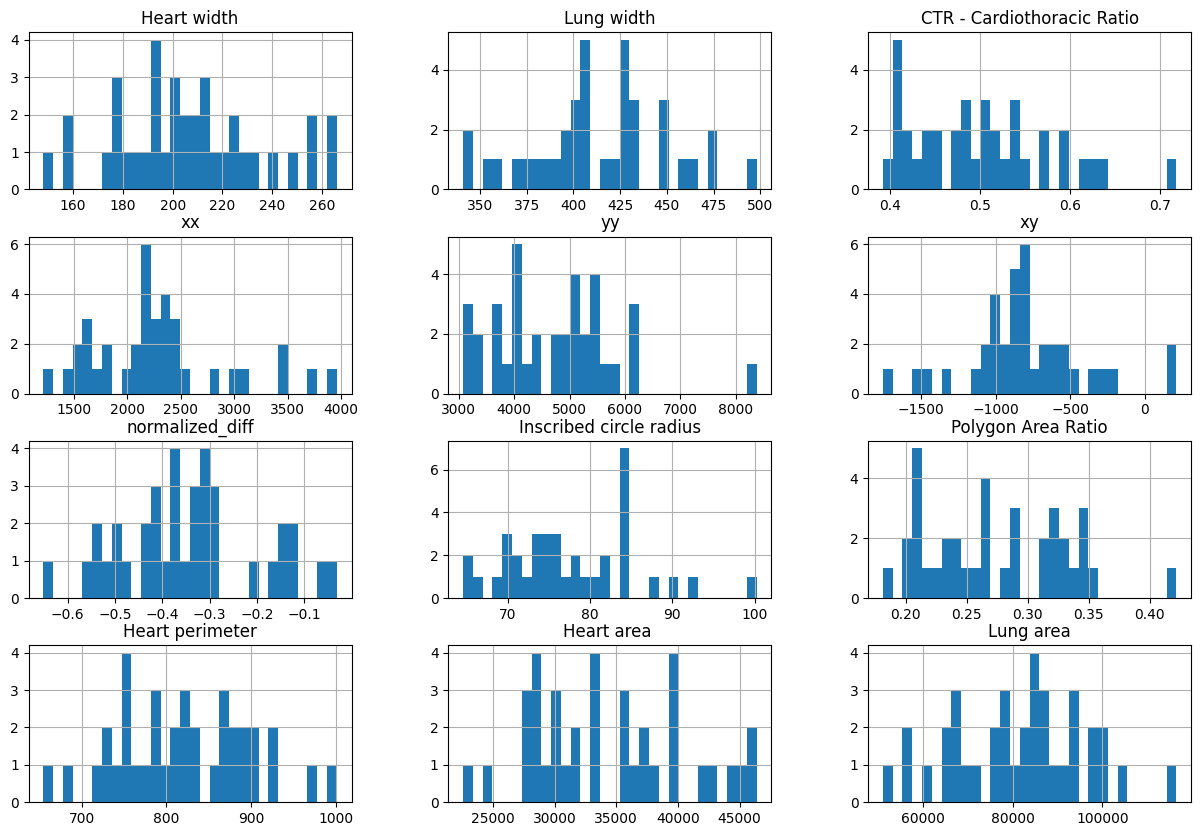

In [111]:
feature_columns = df.columns.drop(['ID', 'Cardiomegaly'])
df[feature_columns].hist(bins=30, figsize=(15, 10))

There are no features that are strongly heavy-tailed. Additionally, we don't have a large amount of data and some outliers may indicate the disease rather than noise.

In [112]:
corr = df.corr()
corr["Cardiomegaly"].sort_values(ascending=False)

Cardiomegaly                  1.000000
Inscribed circle radius       0.454456
Heart area                    0.447708
Heart perimeter               0.424253
xx                            0.383980
Heart width                   0.366739
CTR - Cardiothoracic Ratio    0.297782
yy                            0.250155
Polygon Area Ratio            0.210167
normalized_diff               0.170306
ID                            0.158145
Lung area                     0.137400
Lung width                    0.096037
xy                           -0.229837
Name: Cardiomegaly, dtype: float64

### Data Preparing
Features related to heart size have the biggest impact on the results. To improve the model performance, additional ratio-based features are created.

In [113]:
# Separate features and target
X = df.drop(['ID', 'Cardiomegaly'], axis=1)
y = df['Cardiomegaly']


In [ ]:
# Create new features
X['Width Ratio'] = X['Heart width'] / X['Lung width']
X['Area Ratio'] = X['Heart area '] / X['Lung area']

print(f"\nFeature columns: {X.columns.tolist()}")


Feature columns: ['Heart width', 'Lung width', 'CTR - Cardiothoracic Ratio', 'xx', 'yy', 'xy', 'normalized_diff', 'Inscribed circle radius', 'Polygon Area Ratio', 'Heart perimeter', 'Heart area ', 'Lung area', 'Width Ratio', 'Area Ratio']


Due to the limited amount of data, both training and test sets are stratified to ensure a similar ratio of positive and negative cases

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [116]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)